In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath('..',)
if module_path not in sys.path:
    print(f'Adding {module_path} to PYTHONPATH')
    sys.path.insert(0, module_path)

Adding C:\Users\orduk\PycharmProjects\AT2024Port to PYTHONPATH


In [2]:
from research.alpha_study import get_alpha_stats,qcutStats,csv_download_link,remove_outliers
import perspective
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List


In [3]:
alpha_stats_raw = get_alpha_stats(meanAdjust = False)
alpha_stats = alpha_stats_raw.dropna()


100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [03:14<00:00,  1.77it/s]


In [9]:
RETURN_COLS = ['Return_1bd', 'Return_2bd', 'Return_3bd', 'Return_4bd',
        'Return_1wk', 'Return_2wk', 'Return_3wk', 'Return_4wk']
orig_shape = alpha_stats.shape
orig_cusips = set(alpha_stats.index.unique())
clean_stats, dropped_stats,lowerb,upperb  = remove_outliers(alpha_stats,['Return_1wk'], .9999,.0001)
print(f'Dropped {dropped_stats.shape[0]} rows in {len(dropped_stats.index.unique())} cusips')

pd.concat([lowerb,upperb],axis=1)
alpha_stats = clean_stats

Dropped 34 rows in 28 cusips


In [10]:
alpha_stats[['Alpha']+RETURN_COLS].corr()

,Alpha,Return_1bd,Return_2bd,Return_3bd,Return_4bd,Return_1wk,Return_2wk,Return_3wk,Return_4wk
Alpha,1.000000,0.005378,0.008835,0.008383,0.006911,0.004101,0.005495,0.005756,0.004990
Return_1bd,0.005378,1.000000,0.734803,0.626859,0.563394,0.507150,0.366205,0.313320,0.249332
Return_2bd,0.008835,0.734803,1.000000,0.822977,0.725779,0.640608,0.472237,0.376668,0.314108
Return_3bd,0.008383,0.626859,0.822977,1.000000,0.873839,0.793553,0.562077,0.446297,0.381555
Return_4bd,0.006911,0.563394,0.725779,0.873839,1.000000,0.906117,0.624891,0.523994,0.449082
Return_1wk,0.004101,0.507150,0.640608,0.793553,0.906117,1.000000,0.660952,0.546112,0.472024
Return_2wk,0.005495,0.366205,0.472237,0.562077,0.624891,0.660952,1.000000,0.798986,0.688783
Return_3wk,0.005756,0.313320,0.376668,0.446297,0.523994,0.546112,0.798986,1.000000,0.853256
Return_4wk,0.004990,0.249332,0.314108,0.381555,0.449082,0.472024,0.688783,0.853256,1.000000


<Axes: xlabel='ForecastDate'>

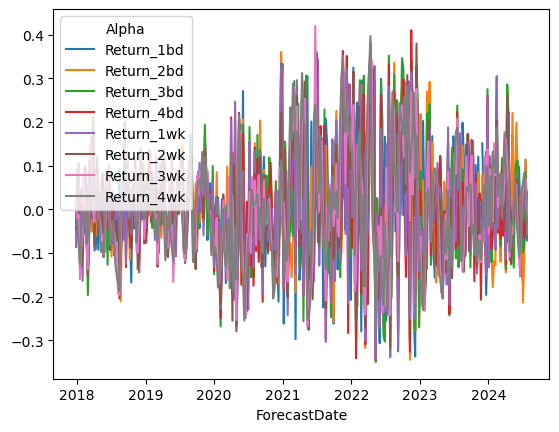

In [11]:
corr_by_period = alpha_stats.groupby('ForecastDate').apply(\
    lambda g: g[['Alpha']+RETURN_COLS].corr()['Alpha'],include_groups=False)
corr_by_period[RETURN_COLS].plot()

In [7]:
alpha_stats.ForecastDate = pd.to_datetime(alpha_stats.ForecastDate)

C:\Users\orduk\AppData\Local\Temp\ipykernel_29852\3293925158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_stats.ForecastDate = pd.to_datetime(alpha_stats.ForecastDate)


In [12]:
from scipy.stats import linregress
#The below shows that there is no strong statistical relationship between alpha forecasts and returns at any horizon
regRegresults = [ linregress(alpha_stats[R], alpha_stats.Alpha ) for R in RETURN_COLS ]
pd.DataFrame( index = RETURN_COLS, columns=['slope','intercept','rvalue','pvalue','stderr'],
    data=[ [r.slope,r.intercept,r.rvalue, r.pvalue, r.stderr ] for r in [ linregress(alpha_stats[R], alpha_stats.Alpha ) for R in RETURN_COLS ] ])


,slope,intercept,rvalue,pvalue,stderr
Return_1bd,0.006833,3.188607,0.005378,0.030786,0.003164
Return_2bd,0.008313,3.187666,0.008835,0.000388,0.002343
Return_3bd,0.006224,3.187902,0.008383,0.000760,0.001848
Return_4bd,0.004576,3.187532,0.006911,0.005513,0.001649
Return_1wk,0.002423,3.188217,0.004101,0.099584,0.001471
Return_2wk,0.002249,3.187733,0.005495,0.027330,0.001019
Return_3wk,0.001889,3.187433,0.005756,0.020795,0.000817
Return_4wk,0.001406,3.187438,0.004990,0.045079,0.000702


In [13]:
#This shows no evidence that analyst alpha is strong in any particular sector either.
sectors = alpha_stats.PrimFactorCode.unique().tolist()
data=[ [r.slope,r.intercept,r.rvalue, r.pvalue, r.stderr ] for r in \
       [ linregress(alpha_stats[alpha_stats.PrimFactorCode==s].Return_1bd, alpha_stats[alpha_stats.PrimFactorCode==s].Alpha ) for s in sectors ] ] 

pd.DataFrame(index=sectors,data=data,columns = ['slope','intercept','rvalue','pvalue','stderr'])

,slope,intercept,rvalue,pvalue,stderr
USIS,0.009293,3.817358,0.008620,0.416624,0.011439
USHE,0.015596,2.952671,0.012725,0.142582,0.010636
USHT,0.007652,3.330391,0.007493,0.453052,0.010198
USCM,0.029276,4.161604,0.022951,0.051233,0.015015
USBK,0.045501,4.285564,0.038466,0.004930,0.016177
USMT,-0.000521,3.780053,-0.000527,0.960702,0.010583
USIT,-0.009258,2.151655,-0.007117,0.334381,0.009590
USTR,0.001356,3.036555,0.001102,0.942862,0.018912
USRE,-0.010665,3.532296,-0.011399,0.232472,0.008931
USBT,-0.003906,1.260088,-0.002193,0.879246,0.025710


In [ ]:
#means=100*alpha_stats.groupby([pd.qcut(alpha_stats.Alpha,3)],observed=False)[RETURN_COLS].mean()
means = qcutStats(alpha_stats,'Alpha',4, RETURN_COLS)
csv_download_link(means,'ttt.csv',True)
means

C:\Users\orduk\PycharmProjects\AT2024Port\dashboards\ttt.csv

In [18]:
def long_short(long_cutoff=0, short_cutoff=0):
    def x(group):
        return group[group.Alpha>long_cutoff][RETURN_COLS].mean().fillna(0) - \
            group[group.Alpha<short_cutoff][RETURN_COLS].mean().fillna(0)
    return x


<Axes: title={'center': 'All Sectors 1wk cumprod'}, xlabel='ForecastDate'>

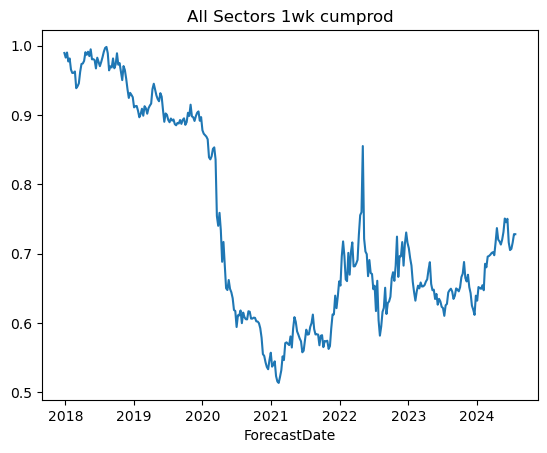

In [71]:
#Simple L/S strategy - equal weight long/short alphas equally
avgPctReturns = alpha_stats.groupby('ForecastDate').apply(long_short(0,0),include_groups=False).reset_index()\
    .sort_values('ForecastDate').set_index('ForecastDate')     
cumPortReturns = (1+.01*avgPctReturns['Return_1wk']).cumprod()
cumPortReturns.plot(title='All Sectors 1wk cumprod')
#print('TAIL', cumPortReturns.tail(1))
#(1+.01*alpha_stats[alpha_stats.PrimFactorCode.isin(['USAD', 'USBC'])].groupby('ForecastDate').apply(long_short(0,0),include_groups=False)['Return_1wk']).cumprod().plot()  

,means,counts
PrimFactorCode,,
USIT,0.997338,18398
USBT,0.999480,4803
USHT,0.999515,10029
USHE,0.999569,13279
USCM,0.999732,7216
USIS,0.999814,8883
USRT,1.000059,4594
USBK,1.000187,5341
USCD,1.000396,11982


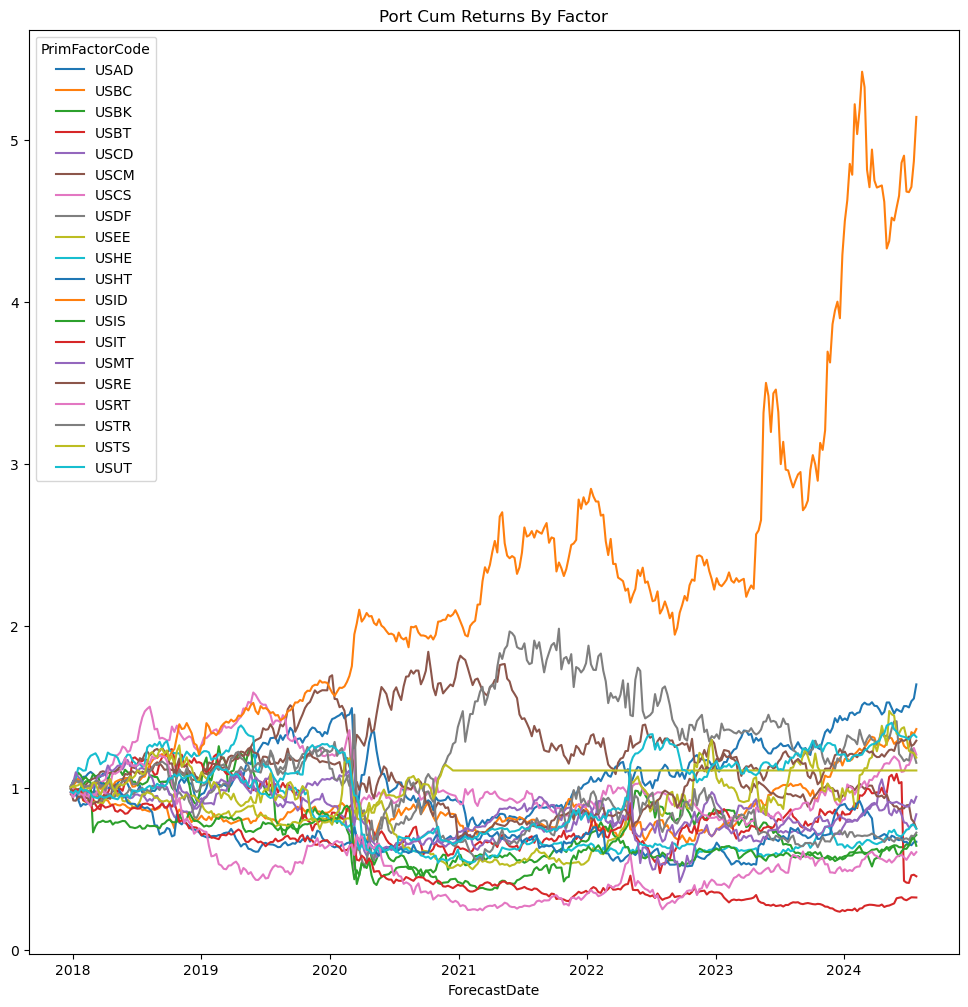

In [85]:
ls_sector = alpha_stats.groupby(['ForecastDate','PrimFactorCode']).apply(long_short(),include_groups=False).reset_index()
pivot_df = ls_sector.pivot(index='ForecastDate', columns='PrimFactorCode', values='Return_1wk').fillna(0)
pivot_df = 1+.01*pivot_df
pivot_df
#(1+ls_sector[ls_sector.PrimFactorCode=='USTS']['Return_1wk']/100.).cumprod()
pivot_df.cumprod().plot(figsize=(12, 12), title='Port Cum Returns By Factor')

#terminal = pivot_df.cumprod().tail(1)
#strongSector = [s for s in terminal.columns if terminal[s].iloc[0]>0]
#print(terminal,strongSector)

#strongSectors = set(terminal[terminal>0].index)
#print('Strong sectors', strongSectors)
means = pivot_df.mean().sort_values()
counts = alpha_stats.groupby('PrimFactorCode')['Return_1wk'].count()
meancounts = pd.DataFrame()
meancounts['means'] = means
meancounts['counts'] = counts
meancounts

<Axes: xlabel='ForecastDate'>

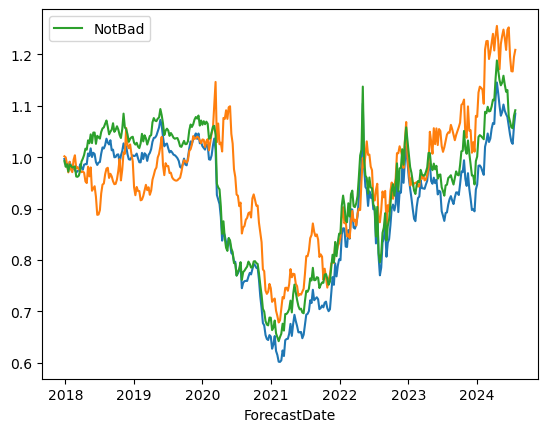

In [89]:

strongSectors = 'USRT USBK USCD USTR USTS USMT USCS USRE USUT USBC USEE USDF USAD USID'.split()
strongSectorReturns = alpha_stats[alpha_stats.PrimFactorCode.isin(strongSectors)].groupby(['ForecastDate']).apply(long_short(),include_groups=False)['Return_1wk']
strongestSectorReturns = alpha_stats[alpha_stats.PrimFactorCode.isin(['USID','USAD','USDF', 'USEE'])].groupby(['ForecastDate']).apply(long_short(),include_groups=False)['Return_1wk']
badSectors =  'USIT USHT USHE'.split()
notBadSectorReturns = alpha_stats[~alpha_stats.PrimFactorCode.isin(badSectors)].groupby(['ForecastDate']).apply(long_short(),include_groups=False)['Return_1wk']

(1+.01*strongSectorReturns).cumprod().plot()
(1+.01*strongestSectorReturns).cumprod().plot()
nb = (1+.01*notBadSectorReturns).cumprod(); nb.name = 'NotBad'
nb.plot(legend=True)



In [72]:
from datetime import date
pivot_df['USBK'].index[304]
sus = pd.to_datetime(date(2023,10,25))
pivot_df.loc[sus]
susbk = alpha_stats[(alpha_stats.ForecastDate==sus) & (alpha_stats.PrimFactorCode == 'USBK') ]
csv_download_link(susbk.reset_index(), 'ttt2.csv',True)

C:\Users\orduk\PycharmProjects\AT2024Port\dashboards\ttt2.csv

Press enter to delete the file after you have downloaded it. 


<Axes: xlabel='ForecastDate'>

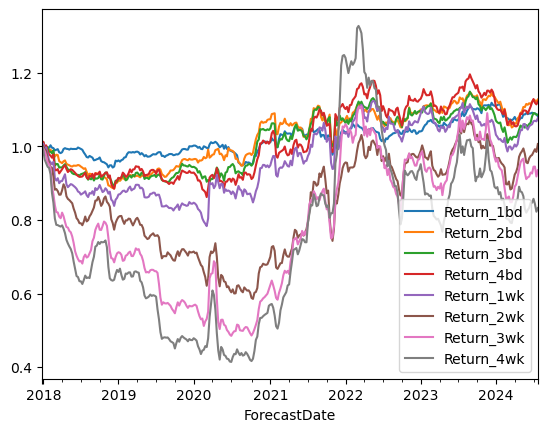

In [42]:
usbk = alpha_stats[alpha_stats.PrimFactorCode=='USBK'].groupby('ForecastDate').apply(long_short(0,0),include_groups=False).reset_index()\
    .sort_values('ForecastDate').set_index('ForecastDate')   
(1+.01*usis).cumprod().plot()
